In [5]:
import json
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from collections import defaultdict, Counter
from tabulate import tabulate

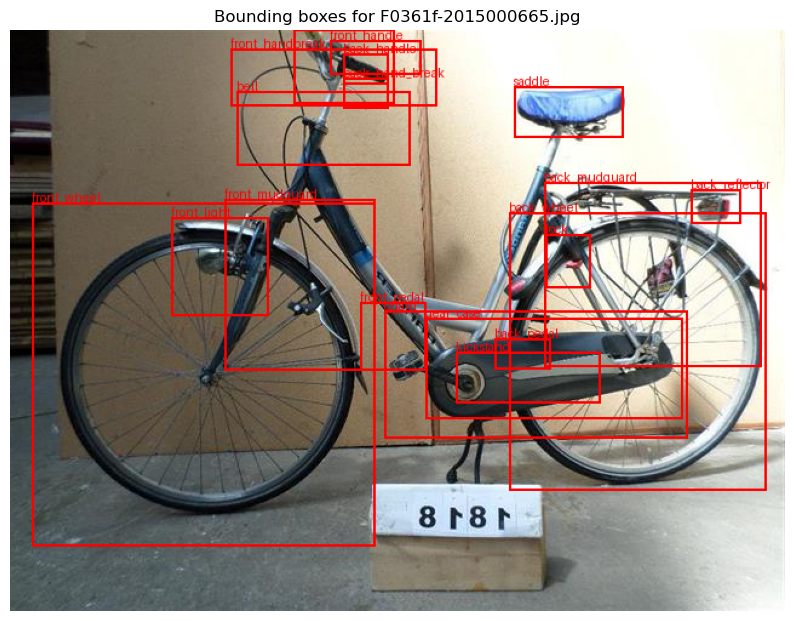

In [6]:
# Paths
annotations_path = "../../data/processed/final_annotations.json"
images_dir = "../../data/images"

# Load annotations
with open(annotations_path, "r") as f:
    annotations = json.load(f)

# Get all image filenames from the annotation
image_filenames = list(annotations["images"].keys())

# Select specific ranges
selected_filenames = (
    image_filenames[2000:2010]
    + image_filenames[5000:5010]
    + image_filenames[3950:3960]
    + image_filenames[7745:7755]
)

# Function to visualize bounding boxes on a given image filename
def visualize_image(filename):
    image_path = os.path.join(images_dir, filename)

    if not os.path.exists(image_path):
        print(f"Image not found: {filename}")
        return

    if filename not in annotations["images"]:
        print(f"No annotation found for: {filename}")
        return

    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    parts = annotations["images"][filename].get("available_parts", [])
    for part in parts:
        # if part["part_name"] == "steer":
            bbox = part["absolute_bounding_box"]
            part_name = part["part_name"]
            left = bbox["left"]
            top = bbox["top"]
            right = left + bbox["width"]
            bottom = top + bbox["height"]

            draw.rectangle([left, top, right, bottom], outline="red", width=2)
            draw.text((left, top - 10), part_name, fill="red")

    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title(f"Bounding boxes for {filename}")
    plt.axis("off")
    plt.show()

# Visualize selected batches
# for filename in selected_filenames:
#     visualize_image(filename)

# Example usage for a single specific image:
visualize_image("F0361f-2015000665.jpg")


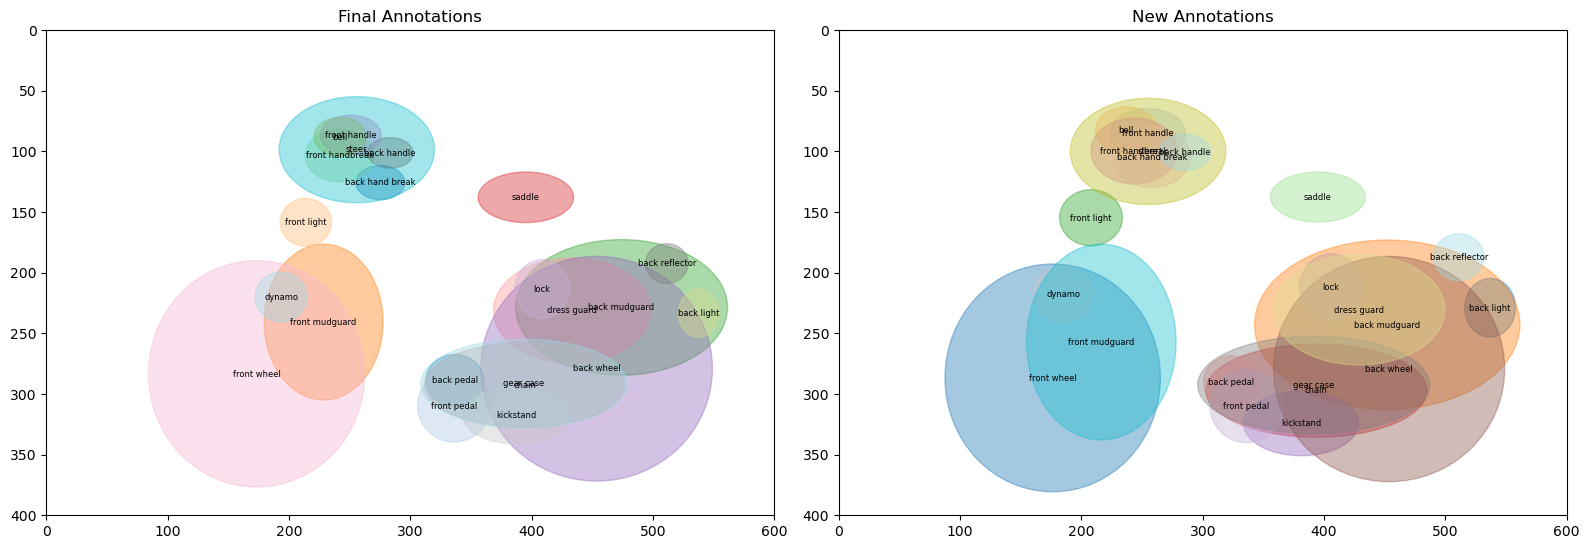

In [7]:
def load_avg_positions(annotations_path):
    with open(annotations_path, 'r') as f:
        annotations = json.load(f)

    all_parts = annotations['all_parts']
    images = annotations['images']

    part_positions = {part: [] for part in all_parts}
    part_sizes = {part: [] for part in all_parts}

    for img_data in images.values():
        for part in img_data['available_parts']:
            name = part['part_name']
            bbox = part['absolute_bounding_box']
            center_x = bbox['left'] + bbox['width'] / 2
            center_y = bbox['top'] + bbox['height'] / 2
            part_positions[name].append((center_x, center_y))
            part_sizes[name].append((bbox['width'], bbox['height']))

    avg_positions = {}
    avg_sizes = {}
    for part in all_parts:
        if part_positions[part]:
            pos_array = np.array(part_positions[part])
            size_array = np.array(part_sizes[part])
            avg_positions[part] = pos_array.mean(axis=0)
            avg_sizes[part] = size_array.mean(axis=0)
        else:
            avg_positions[part] = (0, 0)
            avg_sizes[part] = (0, 0)

    return avg_positions, avg_sizes, all_parts

def plot_avg_positions(ax, avg_positions, avg_sizes, all_parts, title):
    colors = plt.cm.tab20(np.linspace(0, 1, len(all_parts)))

    for i, part in enumerate(all_parts):
        pos = avg_positions[part]
        size = avg_sizes[part]
        if size[0] > 0 and size[1] > 0:
            ellipse = patches.Ellipse((pos[0], pos[1]), width=size[0], height=size[1], 
                                      color=colors[i], alpha=0.4)
            ax.add_patch(ellipse)
            ax.text(pos[0], pos[1], part.replace('_', ' '), ha='center', va='center', fontsize=6)
    
    ax.set_xlim(0, 600)
    ax.set_ylim(400, 0)
    ax.set_aspect('equal')
    ax.set_title(title)

final_path = "../../data/processed/final_annotations.json"
new_path = "../../data/processed/new_annotations.json"

final_avg_positions, final_avg_sizes, final_all_parts = load_avg_positions(final_path)
new_avg_positions, new_avg_sizes, new_all_parts = load_avg_positions(new_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

plot_avg_positions(axes[0], final_avg_positions, final_avg_sizes, final_all_parts, "Final Annotations")
plot_avg_positions(axes[1], new_avg_positions, new_avg_sizes, new_all_parts, "New Annotations")

plt.tight_layout()
plt.show()


In [8]:
with open('../../data/raw/train_annotations.json') as f:
    data = json.load(f)

part_state_counts = defaultdict(Counter)

for image_data in data.values():
    parts = image_data.get('parts', {})
    for part_name, part_info in parts.items():
        state = part_info.get('object_state')
        if state:
            part_state_counts[part_name][state] += 1

headers = ["Part Name", "Intact", "Absent", "Occluded", "Damaged"]
table = []

for part, states in sorted(part_state_counts.items()):
    row = [
        part,
        states.get('intact', 0),
        states.get('absent', 0),
        states.get('occluded', 0),
        states.get('damaged', 0),
    ]
    table.append(row)

# Print the table
print(tabulate(table, headers=headers, tablefmt="fancy_grid"))

╒═════════════════╤══════════╤══════════╤════════════╤═══════════╕
│ Part Name       │   Intact │   Absent │   Occluded │   Damaged │
╞═════════════════╪══════════╪══════════╪════════════╪═══════════╡
│ back_hand_break │     4161 │     2807 │        953 │        79 │
├─────────────────┼──────────┼──────────┼────────────┼───────────┤
│ back_handle     │     5918 │      298 │       1628 │       155 │
├─────────────────┼──────────┼──────────┼────────────┼───────────┤
│ back_light      │     2427 │     3662 │        330 │      1580 │
├─────────────────┼──────────┼──────────┼────────────┼───────────┤
│ back_mudguard   │     6493 │      350 │        634 │       523 │
├─────────────────┼──────────┼──────────┼────────────┼───────────┤
│ back_pedal      │     3636 │       57 │       4242 │        64 │
├─────────────────┼──────────┼──────────┼────────────┼───────────┤
│ back_reflector  │     5227 │     1695 │        918 │       160 │
├─────────────────┼──────────┼──────────┼────────────┼────────